In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string, os
import nltk
import re
import keras
import random
import io
# from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adamax
import sys
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image, ImageDraw, ImageFont
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/MyDrive/DL_mp/data/Songs.csv")
data.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


In [4]:
print("Artists in the data:\n",data.Artist.value_counts())

Artists in the data:
 Artist
Taylor Swift          50
David Bowie           50
Billy Joel            50
Eric Clapton          50
Billie Eilish         50
Leonard Cohen         50
Bruce Springsteen     40
The Beatles           35
Ray LaMontagne        30
Elton John            30
Queen                 30
Frank Sinatra         30
John Denver           30
Bryan Adams           30
​twenty one pilots    30
Nat King Cole         30
Lana Del Rey          30
Vance Joy             30
George Michael        30
Bob Dylan             20
Ed Sheeran            20
Name: count, dtype: int64


In [5]:
print("Size of Dataset:",data.shape)

Size of Dataset: (745, 3)


In [6]:
!pip install nltk

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
#Adding a column of numbers of Characters,words and sentences in each msg
data["No_of_Characters"] = data["Lyrics"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Lyrics"]), axis=1).apply(len)
data["No_of_Lines"] = data["Lyrics"].str.split('\n').apply(len)
data.describe()

,No_of_Characters,No_of_Words,No_of_Lines
count,745.000000,745.000000,745.000000
mean,1403.347651,319.400000,46.277852
std,666.721467,156.163646,21.180531
min,1.000000,1.000000,1.000000
25%,946.000000,215.000000,33.000000
50%,1289.000000,291.000000,44.000000
75%,1714.000000,389.000000,56.000000
max,7267.000000,1652.000000,224.000000


<Figure size 1500x1500 with 0 Axes>

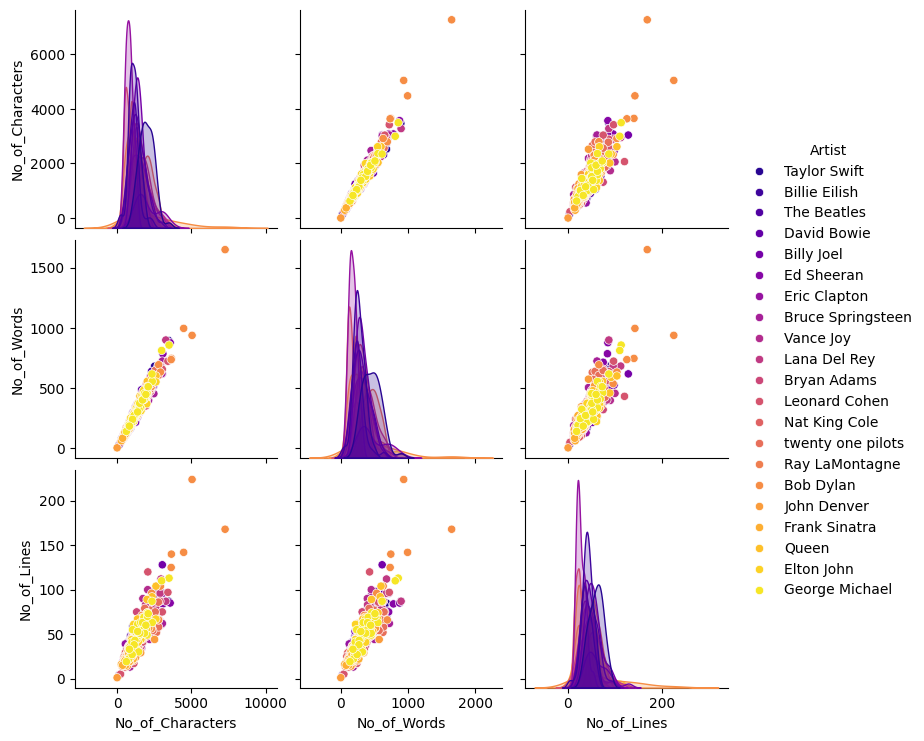

In [9]:
#Plotting the comparative song lengths for various artists
plt.figure(figsize=(15,15))
ax = sns.pairplot(data, hue="Artist", palette="plasma")

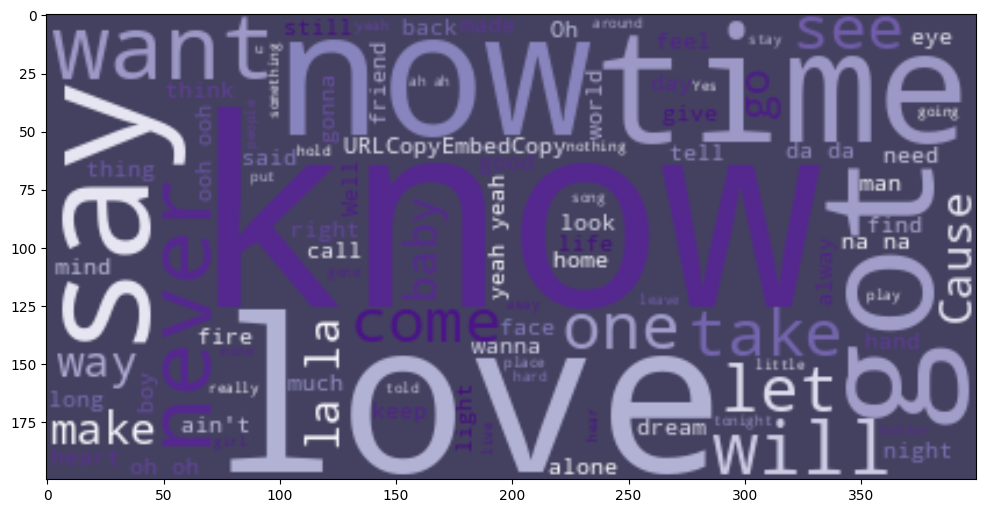

In [10]:
# Generate a word cloud image
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#444160",colormap="Purples", max_words=800).generate(" ".join(data["Lyrics"]))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [11]:
#Lining up all the lyrics to create corpus
Corpus =''
for listitem in data.Lyrics:
    Corpus += listitem

Corpus = Corpus.lower() #converting all alphabets to lowecase
print("Number of unique characters:", len(set(Corpus)))

Number of unique characters: 92


In [12]:
#To See all the unique characters present in the Corpus
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ', 'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', '…', '\u205f', '\ufeff']


In [13]:
#Keeping only a limited set of characters.
to_remove = ['{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ',
             'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”',
             '…', '\u205f', '\ufeff', '!', '&', '(', ')', '*', '-',  '/', ]
for symbol in to_remove:
    Corpus = Corpus.replace(symbol," ")

In [14]:
print("The unique characters:",sorted(set(Corpus)))

The unique characters: ['\n', ' ', '"', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', '?', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [15]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 1045494
Number of unique characters: 47


In [16]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 1045454


In [17]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)

# one hot encode the output variable
y = to_categorical(targets)

In [18]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

#Model's Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense (Dense)               (None, 47)                12079     
                                                                 
Total params: 276271 (1.05 MB)
Trainable params: 276271 (1.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
#Training the Model
history = model.fit(X, y, batch_size=128, epochs=10)

Epoch 1/10
8168/8168 [==============================] - 62s 7ms/step - loss: 2.6211
Epoch 2/10
8168/8168 [==============================] - 53s 6ms/step - loss: 2.2983
Epoch 3/10
8168/8168 [==============================] - 57s 7ms/step - loss: 2.1246
Epoch 4/10
8168/8168 [==============================] - 53s 7ms/step - loss: 2.0007
Epoch 5/10
8168/8168 [==============================] - 53s 7ms/step - loss: 1.9197
Epoch 6/10
8168/8168 [==============================] - 55s 7ms/step - loss: 1.8471
Epoch 7/10
8168/8168 [==============================] - 52s 6ms/step - loss: 1.7934
Epoch 8/10
8168/8168 [==============================] - 61s 7ms/step - loss: 1.7374
Epoch 9/10
8168/8168 [==============================] - 53s 7ms/step - loss: 1.7692
Epoch 10/10
8168/8168 [==============================] - 55s 7ms/step - loss: 1.7695


[Text(0.5, 0, 'Epochs')]

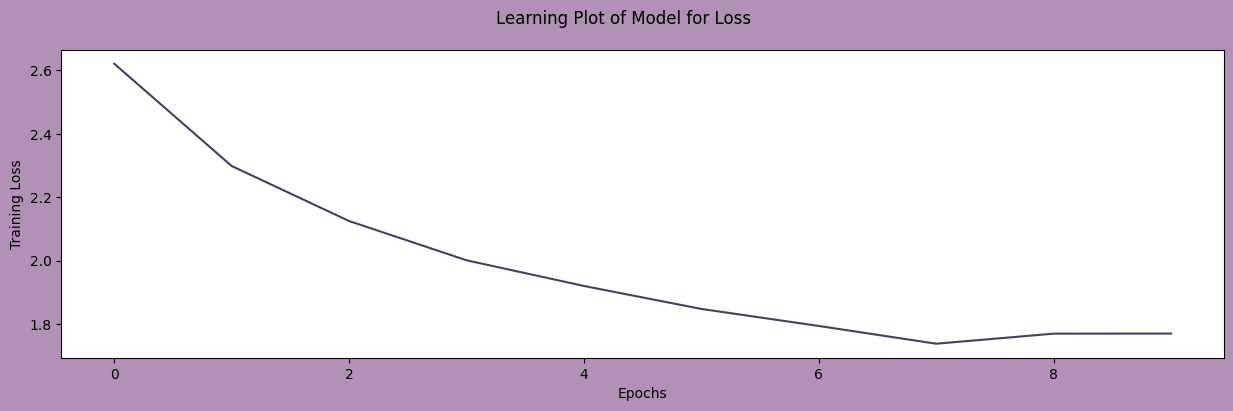

In [20]:
history_df = pd.DataFrame(history.history)
#Plotting the learnings

fig = plt.figure(figsize=(15,4), facecolor="#B291B6")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [21]:
# The function to generate text from model
def Lyrics_Generator(starter,Ch_count): #,temperature=1.0):
    generated= ""
    starter = starter
    seed=[mapping[char] for char in starter]
    generated += starter
    # Generating new text of given length
    for i in range(Ch_count):
        seed=[mapping[char] for char in starter]
        x_pred = np.reshape(seed, (1, len(seed), 1))
        x_pred = x_pred/ float(L_symb)
        prediction = model.predict(x_pred, verbose=0)[0]
        # Getting the index of the next most probable index
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / 1.0
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, prediction, 1)
        index = np.argmax(prediction)
        next_char = reverse_mapping[index]
        # Generating new text
        generated += next_char
        starter = starter[1:] + next_char

    return generated

In [30]:
#Generating a song from the model
song_1 = Lyrics_Generator("the shoe shrunk, and the belts got petit", 400)

In [31]:
song_1

"the shoe shrunk, and the belts got petit\ni was alone in the way\nand the way that you wene to me\n\ni was ald i'm a blackseae \ni'm a blackstar, i'm a blnckent\n\nf've been thinking that woneer woue in my hand\ni was alone in the way\nand the way that you wene to me\n\ni was ald i'm a blackseae \ni'm a blackstar, i'm a blnckent\n\nf've been thinking that woneer woue in my hand\ni was alone in the way\nand the way that you wene to me\n\ni was ald i'm a b"